# Merge the tracks from the same acquisition speed and get integra from 30-50
# 0. Assign the path storing the corrected track no from individual videos

✅Update time interval here.
✅ Set "Path" for Imaris measurements and output.

In [1]:
import os

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from os import listdir
import glob
import pandas as pd
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import scipy.optimize

paths = glob.glob("/content/drive/MyDrive/Shared Colab/CCP lifetime analysis_20241229/B_Same speed/Slow/*.xlsx")
print(paths)
path_save = "/content/drive/MyDrive/Shared Colab/CCP lifetime analysis_20241229/C_Data/GFP/Merged_Slow.xlsx"
Time_interval = 2.136

['/content/drive/MyDrive/Shared Colab/CCP lifetime analysis_20241229/B_Same speed/Slow/CorrectedTrackNo_4_2.xlsx', '/content/drive/MyDrive/Shared Colab/CCP lifetime analysis_20241229/B_Same speed/Slow/CorrectedTrackNo_4_1.xlsx']


# 1. Merge data
## 1.1. Concatenate excel files from the same speed

In [3]:
cdf = [pd.read_excel(excel_names, sheet_name=None).values()
            for excel_names in paths]
out_df = [y for x in cdf for y in x]
df_result = pd.concat(out_df, ignore_index=True)
df_result.to_excel(path_save, index=False)

## 1.2. Group by "Track duration"

In [4]:
Merged_Track = df_result
Merged_Track = Merged_Track.drop(columns=["Track number of Spots", "Measured Track No", "cf", "Time interval", "Lifetime", "Normalized spots population", "Normalized track population", "Unnamed: 0"])
Merged_Track = Merged_Track.groupby("Track Duration").sum().reset_index()
Merged_Track["Lifetime"] = Merged_Track["Track Duration"]*Time_interval
Merged_Track["Normalized track population"] = Merged_Track["Corrected Track No"].apply(lambda x: x/ Merged_Track["Corrected Track No"].sum())
Merged_Track
Merged_Track.to_excel(path_save, index=False)

## 1.3. Plot merged track


Analyzed track no. = 1582.1010190557863


Text(0.5, 1.0, 'Track # vs Lifetime')

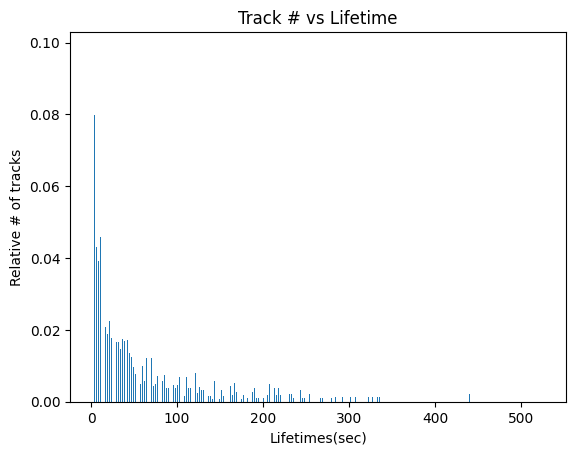

In [5]:
# Plot relative # of tracks vs lifetime
print(f"Analyzed track no. = {Merged_Track['Corrected Track No'].sum()}")
xs = Merged_Track["Lifetime"]
ys = Merged_Track["Normalized track population"]
plt.bar(xs,ys)
plt.xlabel("Lifetimes(sec)")
plt.ylabel("Relative # of tracks")
plt.title("Track # vs Lifetime")

# 2. Dual-Exponential fitting

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


R² of dual exponential fitting= 0.9645617248338458


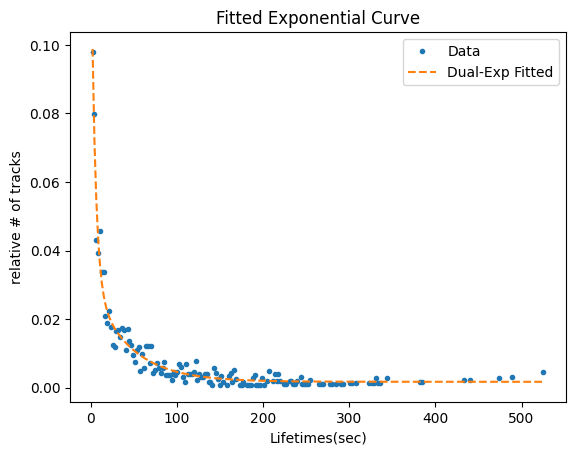

Y = 0.028901220587918747 * e^(-0.022970714413914683 * x) + 0.10877404842303888 * e^(-0.20940035933528509 * x) + 0.0017377183733032723
Tau1d = 43.5336917250707 s; Amplitude 1 = 0.028901220587918747
Tau2d = 4.775540993216885 s; Amplitude 2 = 0.10877404842303888
a1d = 0.028901220587918747 ; t1d = 0.022970714413914683 ; a2d = 0.10877404842303888 ; t2d = 0.20940035933528509; b2 = 0.0017377183733032723


In [6]:
#Define the dualexponential decay funciton
def duExp(x, a1d, t1d, a2d, t2d, b2):
    return a1d * np.exp(-t1d *x) + a2d * np.exp(-t2d * x) + b2

# perform the dualexponential fit
xs = Merged_Track["Lifetime"]
ys = Merged_Track["Normalized track population"]
p0 = (Merged_Track["Normalized track population"].max(), .1, Merged_Track["Normalized track population"].max(), .1,0) # start with values near those we expect
poptd, cvd = scipy.optimize.curve_fit(duExp, xs, ys, p0)
a1d, t1d, a2d, t2d, b2 = poptd
tau1dSec = (1 / t1d)
tau2dSec = (1 / t2d)

# determine quality of the dualexponential fit
squaredDiffs = np.square(ys - duExp(xs, a1d, t1d, a2d, t2d, b2))
squaredDiffsFromMean = np.square(ys - np.mean(ys))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print(f"R² of dual exponential fitting= {rSquared}")

# plot the dualexponential fit results
plt.plot(xs, ys, '.', label="Data")
plt.plot(xs, duExp(xs, a1d, t1d, a2d, t2d, b2), '--', label="Dual-Exp Fitted")
plt.xlabel("Lifetimes(sec)")
plt.ylabel("relative # of tracks")
plt.title("Fitted Exponential Curve")
plt.legend()
plt.show()

# inspect the dualexponential parameters
print(f"Y = {a1d} * e^(-{t1d} * x) + {a2d} * e^(-{t2d} * x) + {b2}")
print(f"Tau1d = {tau1dSec * 1} s; Amplitude 1 = {a1d}")
print(f"Tau2d = {tau2dSec * 1} s; Amplitude 2 = {a2d}")
print(f"a1d = {a1d} ; t1d = {t1d} ; a2d = {a2d} ; t2d = {t2d}; b2 = {b2}")

# 3. Get integral from 30 to 50

In [7]:
f1 = lambda x : a1d * np.exp(-t1d *x) + a2d * np.exp(-t2d * x) + b2
area = integrate.quad(f1, 30, 50)
print(area)

(0.2683680700997137, 2.9794841049892018e-15)
